This notebook reads in the PHANGS CO map images and recasts them in deprojected space. Then it calculates the distance from the SNe to the nearest CO 2-1 emission. 

In [1]:
#import packages and initialize settings
import os
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

plt.rc('text',usetex=True)
fontsize=20
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

import sys
sys.path.append('/Users/nessmayker/Desktop/PythonFunctions')
from deprojectGalaxy import deproject

In [2]:
# Unpack master table to get SNe information
SNe,SNtype,SNra,SNdec,SNGCRRadArcSec,SNGCRPosAng,Galaxy,GalDist,GalRa,GalDec,GalPosAng,GalIncl,NumSNe,TypesSNe,NatFile,NatBeamSize,NatRes,NatInt,NatErr,NatEW,SNNat,pc60Int,pc60Err,pc60EW,SN60,pc90Int,pc90Err,pc90EW,SN90,pc120Int,pc120Err,pc120EW,SN120,pc150Int,pc150Err,pc150EW,SN150,pc500Int,pc500Err,pc500EW,SN500,pc750Int,pc750Err,pc750EW,SN750,pc1000Int,pc1000Err,pc1000EW,SN1000,pc1250Int,pc1250Err,pc1250EW,SN1250,alphaCO = np.loadtxt('../Data/SNeCO_Master_Table.csv', dtype = str, delimiter = ',',unpack=True)
print(len(SNe))

62


In [3]:
# #OPEN CANDIDATE CATALOG AND READ IN RAS, DECS, NAMES
# galaxy = 'NGC4303'
# sne = 'SN1926A'
# image  = '../ALMAmaps/12m+7m+tp_co21_broad_mom0/NGC4303_12m+7m+tp_co21_broad_mom0.fits'
# errimage  = '../ALMAmaps/12m+7m+tp_co21_broad_emom0/NGC4303_12m+7m+tp_co21_broad_emom0.fits'
# alphaCOimg = '../alphaCOmaps/NGC4303_alphaCO21_Sun+20.fits'
# centerCoord = [185.47888, 4.473744]
# # (dist in kpc)
# incl, pa, galDist  = 20.0*u.deg, 310.6*u.deg, 17.6
# SNra, SNdec = 185.48041666666668*u.deg , 4.487972222222222*u.deg
# SNeCoord = [185.48041666666668 , 4.487972222222222]


# Galaxy, SNe = [],[]
# Galaxy.append(galaxy)
# SNe.append(sne)

In [4]:
def int2mass(x, aco, res=150.0):
    area = (res/2.0)**2*np.pi/np.log(2.0)
    y = x * aco * area
    return(y)
    
def mass2int(mass, aco, res=150.0):
    area = (res/2.0)**2*np.pi/np.log(2.0)
    inten = mass / (aco * area)
    return(inten)

def arraySort(variable, distance):
    # sorts variable by shortest distance
    pattern = distance.argsort()
    dist = distance[pattern]
    var = variable[pattern]
    return (var, dist)

def findNearest(varArray, value, SNdistArray, RandDistArray):
    # sorts variable by distance, returning closest with given value and that value
    var, SNdist = arraySort(varArray, SNdistArray) 
    var2, RandDist = arraySort(varArray, RandDistArray)
    ind = np.where(var >= value)
    ind2 = np.where(var2 >= value)
    
    if len(SNdist[ind]) > 0:
        nearestSN    = np.argmin(SNdist[ind])
        nearestRand  = np.argmin(RandDist[ind2])
        nearSNDist   = SNdist[ind][nearestSN] * 1000
        varSNVal     = var[ind][nearestSN]
        nearRandDist = RandDist[ind2][nearestRand] * 1000
    else:
        nearSNDist   = float('nan')
        varSNVal     = float('nan')
        nearRandDist = float('nan')
        
    return(varSNVal, nearSNDist, nearRandDist)
    
def printNearest(galaxy, kind, value, SNRcutoff = 3.0):
    # takes galaxy name, kind of sorting (SNR, Intensity, or Mass), and value we want (min SNR, intensity, or mass) 
    # and returns distance to the nearest molecular cloud and the min value found of kind requested

    SNR, inten, aco, mass, SNdist_kpc, RandDist_kpc = np.genfromtxt("../Data/{}FlatData.txt".format(galaxy),unpack=True, dtype=float, usecols=(4,0,2,3,9,10)) 
    
    #apply SNR cutoff
    intenCut, SNdist_kpcCut, RandDist_kpcCut, massCut = [],[],[],[]
    for i in range(len(inten)):
        if (SNR[i] >= SNRcutoff):
            intenCut.append(inten[i])
            SNdist_kpcCut.append(SNdist_kpc[i])
            RandDist_kpcCut.append(RandDist_kpc[i])
            massCut.append(mass[i])
    
    if kind == 'SNR':
        valFound, nearestMCSN, nearestMCRand = findNearest(np.array(SNR), value, np.array(SNdist_kpc), np.array(RandDist_kpc))    
    elif kind == 'Intensity':
        valFound, nearestMCSN, nearestMCRand = findNearest(np.array(intenCut), value, np.array(SNdist_kpcCut), np.array(RandDist_kpcCut))
    else:
        valFound, nearestMCSN, nearestMCRand = findNearest(np.array(massCut), value, np.array(SNdist_kpcCut), np.array(RandDist_kpcCut))

    return(nearestMCSN, nearestMCRand, valFound)  

In [5]:
inten5  = mass2int(10**5, 6.7)
inten55 = mass2int(10**5.5, 6.7)
inten6  = mass2int(10**6, 6.7)
inten65 = mass2int(10**6.5, 6.7)
inten7  = mass2int(10**7, 6.7)
inten75  = mass2int(10**7.5, 6.7)
print(inten5, inten55, inten6, inten65, inten7, inten75)

0.5854344282657421 1.8513062139982037 5.854344282657421 18.51306213998204 58.543442826574214 185.1306213998204


In [6]:
# Set up intensity histograms for different mass MCs with constant alphaCO
# we take the intensity specified and multiply by alphaCO = 6.7 giving us a generic mass
kind = 'Intensity'
value = inten55

galaxy_55, nearestMCSN_55, nearestMCRand_55, valFound_55 = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_55.append(filestr)
    nearestMCSN_55.append(nearestMCSN)
    nearestMCRand_55.append(nearestMCRand)
    valFound_55.append(valFound)

value = inten6

galaxy_6, nearestMCSN_6, nearestMCRand_6,  valFound_6 = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_6.append(filestr)
    nearestMCSN_6.append(nearestMCSN)
    nearestMCRand_6.append(nearestMCRand)
    valFound_6.append(valFound)

    
value = inten65

galaxy_65, nearestMCSN_65, nearestMCRand_65,  valFound_65 = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_65.append(filestr)
    nearestMCSN_65.append(nearestMCSN)
    nearestMCRand_65.append(nearestMCRand)
    valFound_65.append(valFound)

value = inten7

galaxy_7, nearestMCSN_7, nearestMCRand_7,  valFound_7 = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_7.append(filestr)
    nearestMCSN_7.append(nearestMCSN)
    nearestMCRand_7.append(nearestMCRand)
    valFound_7.append(valFound)   
    
value = inten75

galaxy_75, nearestMCSN_75, nearestMCRand_75,  valFound_75 = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_75.append(filestr)
    nearestMCSN_75.append(nearestMCSN)
    nearestMCRand_75.append(nearestMCRand)
    valFound_75.append(valFound)
    
# Set up intensity histograms for different mass MCs
#These masses are calculated by multiplying the intensity by jiayi's metallicity dependent
#alpha CO for each pixel.
kind = 'Mass'
value = 10**5.5

galaxy_55a, nearestMCSN_55a, nearestMCRand_55a, valFound_55a = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_55a.append(filestr)
    nearestMCSN_55a.append(nearestMCSN)
    nearestMCRand_55a.append(nearestMCRand)
    valFound_55a.append(valFound)

value = 10**6

galaxy_6a, nearestMCSN_6a, nearestMCRand_6a, valFound_6a = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_6a.append(filestr)
    nearestMCSN_6a.append(nearestMCSN)
    nearestMCRand_6a.append(nearestMCRand)
    valFound_6a.append(valFound)

    
value = 10**6.5

galaxy_65a, nearestMCSN_65a, nearestMCRand_65a, valFound_65a = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_65a.append(filestr)
    nearestMCSN_65a.append(nearestMCSN)
    nearestMCRand_65a.append(nearestMCRand)
    valFound_65a.append(valFound)

value = 10**7

galaxy_7a, nearestMCSN_7a, nearestMCRand_7a, valFound_7a = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_7a.append(filestr)
    nearestMCSN_7a.append(nearestMCSN)
    nearestMCRand_7a.append(nearestMCRand)
    valFound_7a.append(valFound)   
    
value = 10**7.5

galaxy_75a, nearestMCSN_75a, nearestMCRand_75a, valFound_75a = [],[],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMCSN, nearestMCRand, valFound = printNearest(filestr, kind, value)
    galaxy_75a.append(filestr)
    nearestMCSN_75a.append(nearestMCSN)
    nearestMCRand_75a.append(nearestMCRand)
    valFound_75a.append(valFound)

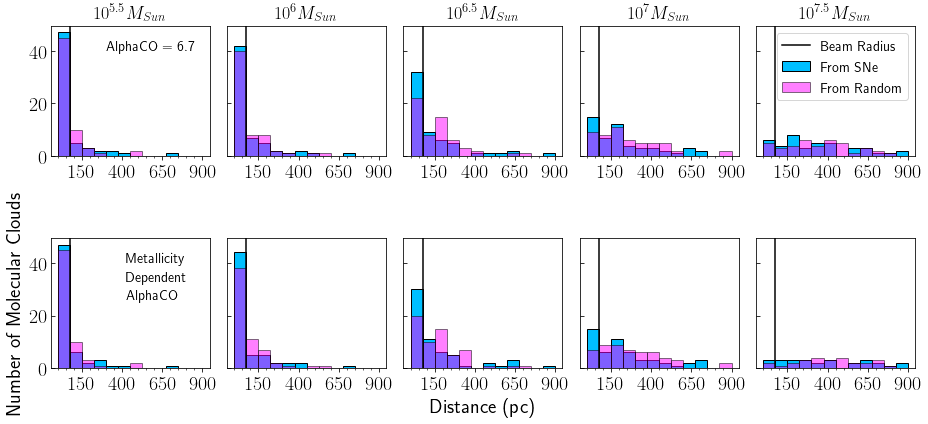

In [7]:
#Plot Histograms

binNum    = [0, 75, 150, 225, 300, 375, 450, 525, 600, 675, 750, 825, 900]
#binNum    = [0, 25,50,75, 100,150, 200, 250, 300, 350, 400, 450, 500, 550,600, 650,700, 750, 800,850, 900]
minorTicks = [0, 50, 100, 200, 250, 300, 350, 450, 500, 550,600, 700, 750, 800,850]
majorTicks = [150,400,650,900]
# minorTicks = [0,75, 225, 300, 375, 450, 600, 675, 750, 825]
# majorTicks = [150, 525, 900]
color1, color2, color3 = 'deepskyblue', 'magenta', 'black'
label1 = 'From SNe'
label2 = 'From Random'
label3 = 'Beam Radius'
fsize = 18
fig, axs = plt.subplots(2, 5, sharex=False, sharey = True, tight_layout=True)
fig.set_figheight(6)
fig.set_figwidth(13)
plt.tick_params(axis='y', direction = 'in')

axs[0,0].set_title(r'$10^{5.5} M_{Sun}$', fontsize = fsize)
axs[0,0].text(300, 40, 'AlphaCO = 6.7', fontsize=14)
axs[0,0].hist(nearestMCSN_55, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,0].hist(nearestMCRand_55, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[0,0].axvline(75, color=color3, label = label3)
axs[0,0].set_xticks(ticks=majorTicks)
axs[0,0].set_xticks(ticks=minorTicks, minor=True)
axs[0,0].tick_params(axis='y', direction = 'in')

axs[0,1].set_title(r'$10^{6} M_{Sun}$', fontsize = fsize)
axs[0,1].hist(nearestMCSN_6, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,1].hist(nearestMCRand_6, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[0,1].axvline(75, color=color3, label = label3)
axs[0,1].set_xticks(ticks=majorTicks)
axs[0,1].set_xticks(ticks=minorTicks, minor=True)
axs[0,1].tick_params(axis='y', direction = 'in')

axs[0,2].set_title(r'$10^{6.5} M_{Sun}$', fontsize = fsize)
axs[0,2].hist(nearestMCSN_65, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,2].hist(nearestMCRand_65, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[0,2].axvline(75, color=color3, label = label3)
axs[0,2].set_xticks(ticks=majorTicks)
axs[0,2].set_xticks(ticks=minorTicks, minor=True)
axs[0,2].tick_params(axis='y', direction = 'in')

axs[0,3].set_title(r'$10^{7} M_{Sun}$', fontsize = fsize)
axs[0,3].hist(nearestMCSN_7, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,3].hist(nearestMCRand_7, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[0,3].axvline(75, color=color3, label = label3)
axs[0,3].set_xticks(ticks=majorTicks)
axs[0,3].set_xticks(ticks=minorTicks, minor=True)
axs[0,3].tick_params(axis='y', direction = 'in')

axs[0,4].set_title(r'$10^{7.5} M_{Sun}$', fontsize = fsize)
axs[0,4].hist(nearestMCSN_75, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[0,4].hist(nearestMCRand_75, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[0,4].axvline(75, color=color3, label = label3)
axs[0,4].set_xticks(ticks=majorTicks)
axs[0,4].set_xticks(ticks=minorTicks, minor=True)
axs[0,4].tick_params(axis='y', direction = 'in')

axs[1,0].text(425, 26, 'AlphaCO', fontsize=14)
axs[1,0].text(425, 40, 'Metallicity', fontsize=14)
axs[1,0].text(425, 33, 'Dependent', fontsize=14)
axs[1,0].hist(nearestMCSN_55a, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,0].hist(nearestMCRand_55a, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[1,0].axvline(75, color=color3, label = label3)
axs[1,0].set_xticks(ticks=majorTicks)
axs[1,0].set_xticks(ticks=minorTicks, minor=True)
axs[1,0].tick_params(axis='y', direction = 'in')

axs[1,1].hist(nearestMCSN_6a, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,1].hist(nearestMCRand_6a, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[1,1].axvline(75, color=color3, label = label3)
axs[1,1].set_xticks(ticks=majorTicks)
axs[1,1].set_xticks(ticks=minorTicks, minor=True)
axs[1,1].tick_params(axis='y', direction = 'in')

axs[1,2].hist(nearestMCSN_65a, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,2].hist(nearestMCRand_65a, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[1,2].axvline(75, color=color3, label = label3)
axs[1,2].set_xticks(ticks=majorTicks)
axs[1,2].set_xticks(ticks=minorTicks, minor=True)
axs[1,2].tick_params(axis='y', direction = 'in')

axs[1,3].hist(nearestMCSN_7a, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,3].hist(nearestMCRand_7a, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[1,3].axvline(75, color=color3, label = label3)
axs[1,3].set_xticks(ticks=majorTicks)
axs[1,3].set_xticks(ticks=minorTicks, minor=True)
axs[1,3].tick_params(axis='y', direction = 'in')

axs[1,4].hist(nearestMCSN_75a, bins=binNum,  color = color1, edgecolor='black', label = label1)
axs[1,4].hist(nearestMCRand_75a, bins=binNum, color = color2, edgecolor='black', alpha = 0.5,label = label2)
axs[1,4].axvline(75, color=color3, label = label3)
axs[1,4].set_xticks(ticks=majorTicks)
axs[1,4].set_xticks(ticks=minorTicks, minor=True)
axs[1,4].tick_params(axis='y', direction = 'in')

# axs[0,0].legend(loc='best', fontsize = 14)
# axs[0,1].legend(loc='best', fontsize = 14)
# axs[0,2].legend(loc='best', fontsize = 14)
# axs[0,3].legend(loc='best', fontsize = 14)
axs[0,4].legend(loc='best', fontsize = 14)
# axs[1,0].legend(loc='best', fontsize = 14)
# axs[1,1].legend(loc='best', fontsize = 14)
# axs[1,2].legend(loc='best', fontsize = 14)
# axs[1,3].legend(loc='best', fontsize = 14)
# axs[1,4].legend(loc='best', fontsize = 14)

axs[1,0].set_ylabel('Number of Molecular Clouds', fontsize = 20)
axs[1,2].set_xlabel('Distance (pc)', fontsize = 20)

fig.savefig('../Figures/Hist_nearestMCs_withRand.png')


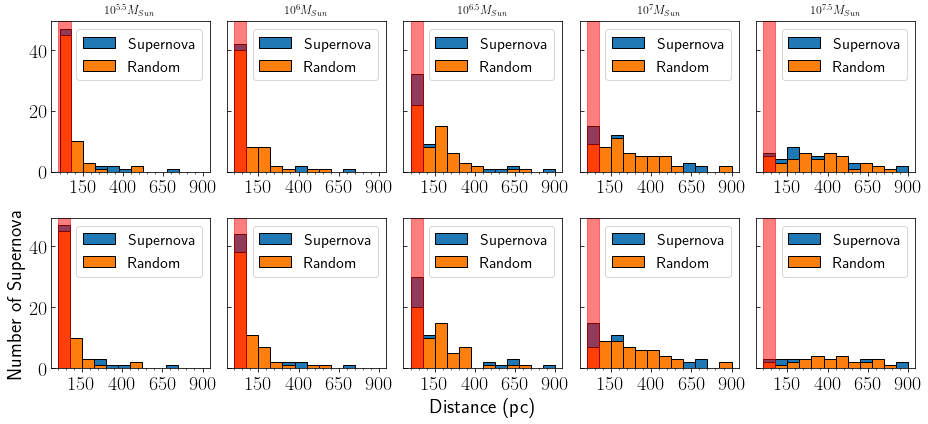

In [8]:
#Plot Histograms

binNum    = [0, 75, 150, 225, 300, 375, 450, 525, 600, 675, 750, 825, 900]
#binNum    = [0, 25,50,75, 100,150, 200, 250, 300, 350, 400, 450, 500, 550,600, 650,700, 750, 800,850, 900]
minorTicks = [0, 50, 100, 200, 250, 300, 350, 450, 500, 550,600, 700, 750, 800,850]
majorTicks = [150,400,650,900]
# minorTicks = [0,75, 225, 300, 375, 450, 600, 675, 750, 825]
# majorTicks = [150, 525, 900]


fig, axs = plt.subplots(2, 5, sharex=False, sharey = True, tight_layout=True)
fig.set_figheight(6)
fig.set_figwidth(13)
plt.tick_params(axis='y', direction = 'in')

axs[0,0].set_title(r'$10^{5.5} M_{Sun}$')
axs[0,0].hist(nearestMCSN_55, bins=binNum,  edgecolor='black', label = "Supernova")
axs[0,0].hist(nearestMCRand_55, bins=binNum,  edgecolor='black', label = "Random")
axs[0,0].axvspan(-10, 75, alpha=0.5, color='red')
axs[0,0].set_xticks(ticks=majorTicks)
axs[0,0].set_xticks(ticks=minorTicks, minor=True)
axs[0,0].tick_params(axis='y', direction = 'in')

axs[0,1].set_title(r'$10^{6} M_{Sun}$')
axs[0,1].hist(nearestMCSN_6, bins=binNum, edgecolor='black', label = "Supernova")
axs[0,1].hist(nearestMCRand_6, bins=binNum,  edgecolor='black', label = "Random")
axs[0,1].axvspan(0, 75, alpha=0.5, color='red')
axs[0,1].set_xticks(ticks=majorTicks)
axs[0,1].set_xticks(ticks=minorTicks, minor=True)
axs[0,1].tick_params(axis='y', direction = 'in')

axs[0,2].set_title(r'$10^{6.5} M_{Sun}$')
axs[0,2].hist(nearestMCSN_65, bins=binNum, edgecolor='black', label = "Supernova")
axs[0,2].hist(nearestMCRand_65, bins=binNum, edgecolor='black', label = "Random")
axs[0,2].axvspan(0, 75, alpha=0.5, color='red')
axs[0,2].set_xticks(ticks=majorTicks)
axs[0,2].set_xticks(ticks=minorTicks, minor=True)
axs[0,2].tick_params(axis='y', direction = 'in')

axs[0,3].set_title(r'$10^{7} M_{Sun}$')
axs[0,3].hist(nearestMCSN_7, bins=binNum, edgecolor='black', label = "Supernova")
axs[0,3].hist(nearestMCRand_7, bins=binNum, edgecolor='black', label = "Random")
axs[0,3].axvspan(0, 75, alpha=0.5, color='red')
axs[0,3].set_xticks(ticks=majorTicks)
axs[0,3].set_xticks(ticks=minorTicks, minor=True)
axs[0,3].tick_params(axis='y', direction = 'in')

axs[0,4].set_title(r'$10^{7.5} M_{Sun}$')
axs[0,4].hist(nearestMCSN_75, bins=binNum, edgecolor='black', label = "Supernova")
axs[0,4].hist(nearestMCRand_75, bins=binNum, edgecolor='black', label = "Random")
axs[0,4].axvspan(0, 75, alpha=0.5, color='red')
axs[0,4].set_xticks(ticks=majorTicks)
axs[0,4].set_xticks(ticks=minorTicks, minor=True)
axs[0,4].tick_params(axis='y', direction = 'in')

axs[0,0].legend(loc='best', fontsize = 16)
axs[0,1].legend(loc='best', fontsize = 16)
axs[0,2].legend(loc='best', fontsize = 16)
axs[0,3].legend(loc='best', fontsize = 16)
axs[0,4].legend(loc='best', fontsize = 16)


axs[1,0].hist(nearestMCSN_55a, bins=binNum, edgecolor='black', label = "Supernova")
axs[1,0].hist(nearestMCRand_55a, bins=binNum, edgecolor='black', label = "Random")
axs[1,0].axvspan(0, 75, alpha=0.5, color='red')
axs[1,0].set_xticks(ticks=majorTicks)
axs[1,0].set_xticks(ticks=minorTicks, minor=True)
axs[1,0].tick_params(axis='y', direction = 'in')

axs[1,1].hist(nearestMCSN_6a, bins=binNum, edgecolor='black', label = "Supernova")
axs[1,1].hist(nearestMCRand_6a, bins=binNum, edgecolor='black', label = "Random")
axs[1,1].axvspan(0, 75, alpha=0.5, color='red')
axs[1,1].set_xticks(ticks=majorTicks)
axs[1,1].set_xticks(ticks=minorTicks, minor=True)
axs[1,1].tick_params(axis='y', direction = 'in')

axs[1,2].hist(nearestMCSN_65a, bins=binNum, edgecolor='black', label = "Supernova")
axs[1,2].hist(nearestMCRand_65a, bins=binNum, edgecolor='black', label = "Random")
axs[1,2].axvspan(0, 75, alpha=0.5, color='red')
axs[1,2].set_xticks(ticks=majorTicks)
axs[1,2].set_xticks(ticks=minorTicks, minor=True)
axs[1,2].tick_params(axis='y', direction = 'in')

axs[1,3].hist(nearestMCSN_7a, bins=binNum, edgecolor='black', label = "Supernova")
axs[1,3].hist(nearestMCRand_7a, bins=binNum, edgecolor='black', label = "Random")
axs[1,3].axvspan(0, 75, alpha=0.5, color='red')
axs[1,3].set_xticks(ticks=majorTicks)
axs[1,3].set_xticks(ticks=minorTicks, minor=True)
axs[1,3].tick_params(axis='y', direction = 'in')

axs[1,4].hist(nearestMCSN_75a, bins=binNum, edgecolor='black', label = "Supernova")
axs[1,4].hist(nearestMCRand_75a, bins=binNum, edgecolor='black', label = "Random")
axs[1,4].axvspan(0, 75, alpha=0.5, color='red')
axs[1,4].set_xticks(ticks=majorTicks)
axs[1,4].set_xticks(ticks=minorTicks, minor=True)
axs[1,4].tick_params(axis='y', direction = 'in')

axs[1,0].legend(loc='best', fontsize = 16)
axs[1,1].legend(loc='best', fontsize = 16)
axs[1,2].legend(loc='best', fontsize = 16)
axs[1,3].legend(loc='best', fontsize = 16)
axs[1,4].legend(loc='best', fontsize = 16)

axs[1,0].set_ylabel('Number of Supernova', fontsize = 20)
axs[1,2].set_xlabel('Distance (pc)', fontsize = 20)

fig.savefig('../Figures/Hist_nearestMCs_SNR100cutoff.png')

#print(len(nearestMC_55a), len(nearestMC_6a), len(nearestMC_65a), len(nearestMC_7a), len(nearestMC_75a))

In [9]:
# Set up intensity histograms for different mass MCs with constant alphaCO
kind = 'SNR'
value = 1

galaxy_55, nearestMC_55, valFound_55 = [],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMC, valFound = printNearest(filestr, kind, value)
    galaxy_55.append(filestr)
    nearestMC_55.append(nearestMC)
    valFound_55.append(valFound)

value = 3

galaxy_6, nearestMC_6, valFound_6 = [],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMC, valFound = printNearest(filestr, kind, value)
    galaxy_6.append(filestr)
    nearestMC_6.append(nearestMC)
    valFound_6.append(valFound)

    
value = 5

galaxy_65, nearestMC_65, valFound_65 = [],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMC, valFound = printNearest(filestr, kind, value)
    galaxy_65.append(filestr)
    nearestMC_65.append(nearestMC)
    valFound_65.append(valFound)

value = 70

galaxy_7, nearestMC_7, valFound_7 = [],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMC, valFound = printNearest(filestr, kind, value)
    galaxy_7.append(filestr)
    nearestMC_7.append(nearestMC)
    valFound_7.append(valFound)   
    
value = 200

galaxy_75, nearestMC_75, valFound_75 = [],[],[]

for i in range(len(Galaxy)):
    filestr = Galaxy[i] + '_' + SNe[i] + '_'
    nearestMC, valFound = printNearest(filestr, kind, value)
    galaxy_75.append(filestr)
    nearestMC_75.append(nearestMC)
    valFound_75.append(valFound)
    

ValueError: too many values to unpack (expected 2)

In [ ]:
#Plot Histograms

binNum = 20

fig, axs = plt.subplots(1, 5, sharex=False, sharey = True, tight_layout=True)
fig.set_figheight(3)
fig.set_figwidth(13)
plt.tick_params(axis='y', direction = 'in')

axs[0].hist(nearestMC_55, bins=binNum, edgecolor='black', label = r'SNR $>$ 1')
axs[0].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[0].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[0].tick_params(axis='y', direction = 'in')

axs[1].hist(nearestMC_6, bins=binNum, edgecolor='black', label = r'SNR $>$ 3')
axs[1].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[1].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[1].tick_params(axis='y', direction = 'in')

axs[2].hist(nearestMC_65, bins=binNum, edgecolor='black', label = r'SNR $>$ 5')
axs[2].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[2].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[2].tick_params(axis='y', direction = 'in')

axs[3].hist(nearestMC_7, bins=binNum, edgecolor='black', label = r'SNR $>$ 70')
axs[3].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[3].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[3].tick_params(axis='y', direction = 'in')

axs[4].hist(nearestMC_75, bins=binNum, edgecolor='black', label = r'SNR $>$ 200')
axs[4].set_xticks(ticks=[100, 300, 500, 700, 900])
axs[4].set_xticks(ticks=[0, 200, 400, 800, 1000], minor=True)
axs[4].tick_params(axis='y', direction = 'in')

axs[0].legend(loc='best', fontsize = 16)
axs[1].legend(loc='best', fontsize = 16)
axs[2].legend(loc='best', fontsize = 16)
axs[3].legend(loc='best', fontsize = 16)
axs[4].legend(loc='best', fontsize = 16)


axs[0].set_ylabel('Number of Supernova', fontsize = 20)
axs[2].set_xlabel('Distance (pc)', fontsize = 20)

fig.savefig('../Figures/Hist_nearestMCs_SNR.png')
print(len(nearestMC_55), len(nearestMC_6), len(nearestMC_65), len(nearestMC_7), len(nearestMC_75))

In [ ]:
!bug!

In [ ]:
from progressbar import ProgressBar

pbar = ProgressBar()

with open('SNeCOMasterCat7m.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,xCoord,yCoord,Type,numSNe,Intensity7m,IntensityErr7m,EW(7m),beamSize', file = text_file)

for i in pbar(range(len(galaxies))):
    found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, map2,map3, naxis1, naxis2, beamSize = check_in_image(ras, decs, SNe, types, images[i], errFiles[i], ewFiles[i])
    plt.figure(figsize=(7, 7))
    logmap = np.log10(map)
    plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)
    intensity = []
    intensityErr = []
    equivalentWidth = []
    equivalentWidthErr = []
    for k in range(len(found_name)):
        stringPrint = found_name[k] + ': ' + found_type[k]
        stringPrint = found_name[k]
        if (len(found_type[k])>1):
            if found_type[k][1] == "I":
                colorCode = 'chartreuse'
            elif found_type[k][1] == "b" or found_type[k][1] == "c":
                colorCode = 'salmon'
            elif found_type[k][1] == "a":
                colorCode = 'deeppink'
            else:
                colorCode = 'cyan'
        else:
            colorCode = 'slategrey'
        xVal = int(round(x_coord[k]))
        yVal = int(round(y_coord[k]))
        if (yVal <= naxis2) and (xVal <= naxis1):
            intensity.append(map[yVal, xVal])
            intensityErr.append(map2[yVal, xVal])
            equivalentWidth.append(map3[yVal, xVal])

        else: 
            intensity.append(np.nan)
            intensityErr.append(np.nan)
            equivalentWidth.append(np.nan)
        plt.plot(x_coord[k], y_coord[k], '*', ms=15, color=colorCode, zorder=10)
        plt.text(x_coord[k]-1, y_coord[k]+4, stringPrint, fontsize=14, fontweight='bold', color=colorCode)
    plt.axis('off')
    plt.title(galaxies[i], fontsize=24, fontweight='bold')
    plt.tight_layout()
    plt.savefig(galaxies[i] + '.png')
    plt.close()
    with open('SNeCOMasterCat7m.txt', 'a') as text_file:
        for j in range(len(found_name)):
            print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",",len(found_name),",", intensity[j],",", intensityErr[j],",",equivalentWidth[j],",",beamSize, file = text_file)


pull data value at x * y coord. error files are also available to go pull the same pixel to find uncertainty and add to the table.
check intensity values from ds9 but use puython to get the calue
error files are emom0
can check read me to see if I can find this stuff.

hdulist[0].data

In [ ]:
galaxies = np.loadtxt('PHANGSGalaxies_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
images = np.loadtxt('PHANGSGalaxiesImg_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
errFiles = np.loadtxt('PHANGSGalaxiesImgErr_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
ewFiles = np.loadtxt('PHANGSGalaxiesEW_12_7_tp.txt', dtype = str, unpack=True, usecols = 0)
pbar = ProgressBar()


with open('SNeCOMasterCat_12_7_tp.txt', 'w') as text_file:
    print('#Galaxy,Supernova,Ra,Dec,xCoord,yCoord,Type,numSNe,Intensity_12_7_tp,IntensityErr_12_7_tp,EW_12_7_tp', file = text_file)

for i in  pbar(range(len(galaxies))):
    found_name, found_type, found_ra, found_dec, x_coord, y_coord, map, map2,map3, naxis1, naxis2, beamSize = check_in_image(ras, decs, SNe, types, images[i], errFiles[i], ewFiles[i])
    plt.figure(figsize=(7, 7))
    #logmap = np.log10(map)
    plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)
    intensity = []
    intensityErr = []
    equivalentWidth = []
    equivalentWidthErr = []
    for k in range(len(found_name)):
        stringPrint = found_name[k] + ': ' + found_type[k]
        stringPrint = found_name[k]
        if (len(found_type[k])>1):
            if found_type[k][1] == "I":
                colorCode = 'black'
            elif found_type[k][1] == "b" or found_type[k][1] == "c":
                colorCode = 'crimson'
            elif found_type[k][1] == "a":
                colorCode = 'purple'
            else:
                colorCode = 'cyan'
        else:
            colorCode = 'blue'
        xVal = int(round(x_coord[k]))
        yVal = int(round(y_coord[k]))
        if (yVal <= naxis2) and (xVal <= naxis1):
            intensity.append(map[yVal, xVal])
            intensityErr.append(map2[yVal, xVal])
            equivalentWidth.append(map3[yVal, xVal])

        else: 
            intensity.append(np.nan)
            intensityErr.append(np.nan)
            equivalentWidth.append(map3[yVal, xVal])
        plt.plot(x_coord[k], y_coord[k], '*', ms=15, color=colorCode, zorder=10)
        plt.text(x_coord[k]-1, y_coord[k]+4, stringPrint, fontsize=14, fontweight='bold', color=colorCode)
    plt.axis('off')
    plt.title(galaxies[i], fontsize=28, fontweight='bold')
    plt.tight_layout()
    plt.savefig(galaxies[i] + '.png')
    plt.close()
    with open('SNeCOMasterCat_12_7_tp.txt', 'a') as text_file:
        for j in range(len(found_name)):
            print(galaxies[i], ",", found_name[j],",", found_ra[j], ",",found_dec[j],",", x_coord[j],",",y_coord[j],",", found_type[j],",",len(found_name),",", intensity[j],",", intensityErr[j],",",equivalentWidth[j], file = text_file)


In [ ]:
# makeFlatHist takes in an image file and returns a sorted array of 
# each intensity value in map. This function removes NANs and turns
# negative intensity values into zeroes
def makeFlatHist(imageFile):
    hdulist = pyfits.open(imageFile)
    map = hdulist[0].data
    intensities = np.ndarray.flatten(map)
    sortInt = np.sort(intensities)
    idx = np.isfinite(sortInt)
    galData = sortInt[idx]
    #galData[galData < 0.0] = 0
    return(galData)
   
# findIntensity takes the intensity of the SN and matches it with 
# the last time that intensity occurs in the sorted array 
def findIntensity(SNInt, galInts):
    galZeroes, galVals = [],[]
    lowestNoise = galInts[0]
    #set all noise terms = 0 (noise is lowest value reflected around zero)
    #sort into zeroes array and intensity values array
    for i in range(len(galInts)):
        if np.fabs(galInts[i]) <= np.fabs(lowestNoise):
            galInts[i] = 0.0
            galZeroes.append(0.0)
        else:
            galVals.append(galInts[i])
    #Find percentile
    found = None
    if SNInt <= np.fabs(lowestNoise):
        foundProb = 0.0
    else:
        for i in range(len(galVals)):
            if galVals[i] == SNInt:
                found = i
        prob = np.linspace(0.0,1.0,len(galVals))
        foundProb = prob[found]
    return(galZeroes, galVals, lowestNoise, foundProb)

In [ ]:
imgFile = "12m+7m+tp_co21_broad_mom0/ngc4303_12m+7m+tp_co21_broad_mom0.fits"
SNInt = 5.85764611457112
SNName = "SN1999gn"

sortArray = makeFlatHist(imgFile)
zeroes, vals, noise, probability = findIntensity(SNInt, sortArray)

print(SNName, probability)

In [ ]:
SNeName, GalaxyName, Intensity, SNType = np.genfromtxt('SNeCOMasterCat_12_7_tp.txt', dtype = str, delimiter = ' , ', unpack=True, usecols = (1,0,8,6))

fltInten = [float(i) for i in Intensity]

Sne, galName, inten, sneType, GalaxyFile = [],[],[],[],[]

#Remove SNe from sample that aren't in map coverage
for i in range(len(SNeName)):
    if np.isfinite(fltInten[i]):
        Sne.append(SNeName[i])
        galName.append(GalaxyName[i])
        inten.append(fltInten[i])
        sneType.append(SNType[i])

#create list of galaxy file names
for i in range(len(galName)):
    if galName[i] == 'circinus':
        string = "12m+7m+tp_co21_broad_mom0/circinus_7m+tp_co21_broad_mom0.fits"
    elif galName[i] == 'ngc0253':
        string = '12m+7m+tp_co21_broad_mom0/ngc0253_7m+tp_co21_broad_mom0.fits'
    elif galName[i] == 'ngc2775':     
        string = '12m+7m+tp_co21_broad_mom0/ngc2775_12m+7m_co21_broad_mom0.fits'
    else:
        string = '12m+7m+tp_co21_broad_mom0/'+galName[i]+'_12m+7m+tp_co21_broad_mom0.fits'
    GalaxyFile.append(string)
    
percentile, medianInten, maxInten, noiseArray = [],[],[],[]

for i in range(len(Sne)):
    sortArray   = makeFlatHist(GalaxyFile[i])
    zeroes, vals, noise, probability = findIntensity(inten[i], sortArray)
    percentile.append(probability)
    noiseArray.append(noise)
    medianInten.append(np.median(vals)) 
    maxInten.append(sortArray[-1])
    
with open('CDF_Vals.txt', 'w') as text_file:
    print('#Galaxy, SNe, Type, Percentile, Intensity, MaxIntensity, Noise', file=text_file)
    for j in range(len(Sne)):
        print(galName[j], ' ', Sne[j], ' ', sneType[j], ' ', percentile[j], ' ', inten[j], maxInten[j], noiseArray[j], file = text_file)

In [ ]:
sortPerc = np.sort(percentile)
xvals = np.linspace(0,1,len(percentile))
maxRatio, medRatio = [],[]
#These should be arrays
for i in range(len(sortPerc)):
    maxRatio.append(inten[i]/maxInten[i])
    medRatio.append(inten[i]/medianInten[i])

maxRatio = np.sort(maxRatio)
medRatio = np.sort(medRatio)

unknown, sortTypeII, sortTypeIa, sortTypeSE = [],[],[],[]
uknMaxRat, TypeIIMaxRat, TypeIaMaxRat, TypeSEMaxRat = [],[],[],[]
uknMedRat, TypeIIMedRat, TypeIaMedRat, TypeSEMedRat = [],[],[],[]

# Type I and 'no' sorted as unknown
for i in range(len(sneType)):
    if (len(sneType[i]) == 1 or sneType[i] == 'no'):
        unknown.append(sortPerc[i])
        uknMaxRat.append(maxRatio[i])
        uknMedRat.append(medRatio[i])
    elif sneType[i][1] == "I":
        sortTypeII.append(sortPerc[i])
        TypeIIMaxRat.append(maxRatio[i])
        TypeIIMedRat.append(medRatio[i])
    elif sneType[i][1] == "a":
        sortTypeIa.append(sortPerc[i])
        TypeIaMaxRat.append(maxRatio[i])
        TypeIaMedRat.append(medRatio[i])
    elif sneType[i][1] == "b" or sneType[i][1] == "c":
        sortTypeSE.append(sortPerc[i]) 
        TypeSEMaxRat.append(maxRatio[i])
        TypeSEMedRat.append(medRatio[i])
            
xvalsII = np.linspace(0,1,len(sortTypeII))
xvalsIa = np.linspace(0,1,len(sortTypeIa))
xvalsSE = np.linspace(0,1,len(sortTypeSE))  
xvalsNo = np.linspace(0,1,len(unknown))    
print(len(sortPerc), len(sortTypeII), len(sortTypeIa),len(sortTypeSE),len(unknown))
    
fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(sortPerc, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(sortTypeII, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(sortTypeIa, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(sortTypeSE, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(unknown, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('COIntCDF.png')

fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(maxRatio, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(TypeIIMaxRat, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(TypeIaMaxRat, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(TypeSEMaxRat, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(uknMaxRat, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity / Maximum Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('MaxRatioCDF.png')

fig = plt.figure(figsize = (7,5))
plt.tick_params(axis='both', direction='in')
plt.plot(medRatio, xvals, ls='-', marker='o', color='black', label = 'All')
plt.plot(TypeIIMedRat, xvalsII, ls='-.', marker='*',ms=9, color='purple', label = 'Type II')
plt.plot(TypeIaMedRat, xvalsIa, ls=':', marker='^', color = 'chocolate', label = 'Type Ia')
plt.plot(TypeSEMedRat, xvalsSE, ls='-', marker='o',color='green',label = 'Type Ib/c')
plt.plot(uknMedRat, xvalsNo, ls='-', marker='<',label = 'Untyped')
plt.axhline(y=0.16, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.50, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.axhline(y=0.84, xmin=0, xmax = 1, ls = '--', color = 'k', alpha = 0.3)
plt.grid('both','both',color='k',alpha = 0.05, linestyle='-', linewidth=2)
plt.ylabel('Fraction of SNe', fontsize = 20)
plt.xlabel('Host Galaxy CO 2-1 Intensity / Median Fraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
fig.savefig('MedRatioCDF.png')